# Техническое задание Маркетинг

## Описание проекта и данных

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:**

Предсказать вероятность покупки в течение 90 дней


**Задачи:**

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование




**Описание данных:**

1) Таблица `apparel-purchases` - данные о покупках клиентов по дням и по товарам. 
   - `client_id` - идентификатор клиента
   - `quantity` - количество единиц товара
   - `price` - цена товара
   - `category_ids` - идентификаторы категорий
   - `date` - дата покупки
   - `message_id` - идентификатор сообщения из рассылки
    
    
2) Таблица `apparel-messages` - рассылки, которые были отправлены клиентам из таблицы покупок.
   - `bulk_campaign_id` - идентификатор рассылки
   - `client_id` - идентификатор клиента 
   - `message_id` - идентификатор сообщения
   - `event` - действие с сообщением (отправлено, открыто, покупка…)
   - `channel` - канал рассылки
   - `date` - дата действия
   - `created_at` - дата-время полностью
     
     
3) Таблица `target` - целевой признак:
  - `client_id` - идентификатор клиента
  - `target` - клиент совершил покупку в целевом периоде



4) `full_campaign_daily_event` - агрегация общей базы рассылок по дням и типам событий
  - `date` - дата
  - `bulk_campaign_id` - идентификатор рассылки
  - `count_event*` - общее количество каждого события event
  - `nunique_event*` - количество уникальных client_id в каждом событии
    
 
 5) `full_campaign_daily_event_channel` - агрегация по дням с учетом событий и каналов рассылки
  - `date` - дата
  - `bulk_campaign_id` - идентификатор рассылки
  - `count_event*_channel*` - общее количество каждого события по каналам
  - `nunique_event*_channel*` - количество уникальных client_id по событиям и каналам

## Импорт библиотек 

In [1]:
# Установка библиотек
!pip install lightgbm

In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Для конвертации списков в корректный формат
from ast import literal_eval

# Установим стили графиков
sns.set_theme(rc={'figure.figsize':(10, 3)})

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [3]:
# Для воспроизводства результатов
RANDOM_STATE = 17

In [4]:
apparel_messages = pd.read_csv('./datasets/apparel-messages.csv')
apparel_purchases = pd.read_csv('./datasets/apparel-purchases.csv')
apparel_target_binary = pd.read_csv('./datasets/apparel-target_binary.csv')
full_campaign_daily_event = pd.read_csv('./datasets/full_campaign_daily_event.csv')
full_campaign_daily_event_channel = pd.read_csv('./datasets/full_campaign_daily_event_channel.csv')

In [5]:
# Функция для отображения данных
def data_info(df):
    print(f'Количество строк - {df.shape[0]}')
    print(f'Количество столбцов - {df.shape[1]}', end='\n\n')
    
    display(df.info())
    display(df.head(3))

In [6]:
data_info(apparel_target_binary)

Количество строк - 49849
Количество столбцов - 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


В целевом признаке всего $49849$ уникальных клиентов. То есть нужно будет собрать датасет с признаками, в котором будут признаки именно для этих $49849$ уникальных клиентов.


Сразу выделим уникальные идентификаторы клиентов из целевого признака.

In [7]:
data_info(apparel_purchases)

Количество строк - 202208
Количество столбцов - 6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


В этой таблице изображена подробная информация о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук. В таблице есть списки идентификаторов, к каким категориям относится товар. 

In [8]:
data_info(apparel_messages)

Количество строк - 12739798
Количество столбцов - 7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


Это самая крупная таблица, которая включает в себя боле 12 млн. строк. Таблица включает рассылки, которые были отправлены клиентам из таблицы покупок. Тип данных в строках `date`, `created_at` нужно изменить на datetime.

In [9]:
data_info(full_campaign_daily_event)

Количество строк - 131072
Количество столбцов - 24

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-

None

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


Агрегация общей базы рассылок по дням и типам событий. Всего в таблице $131072$ строк. Эту таблицу можно использовать для извлечения подробной информации о рассылках.

In [10]:
data_info(full_campaign_daily_event_channel)

Количество строк - 131072
Количество столбцов - 36

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email       

None

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Если нужна информация о рассылках по каналам и событиям, то можно воспользоваться этой базой данных. Нужно также измеить тип данных столбца `date`.


Первые 3 датасета являются главными для создания конечного датасета. Остальные - побочные.

Проверим совпадение индексов клиентов в целевом датасете и в остальных.

In [11]:
print(f"Уникальные клиенты в целевом признаке - {apparel_target_binary['client_id'].nunique()}")

print()

print('Пересечение целевого датасета с apparel_messages -',
     len(set(apparel_messages['client_id']) & set(apparel_target_binary['client_id'])))

print('Пересечение целевого датасета с apparel_purchases -',
      len(set(apparel_purchases['client_id']) & set(apparel_target_binary['client_id'])))

Уникальные клиенты в целевом признаке - 49849

Пересечение целевого датасета с apparel_messages - 41982
Пересечение целевого датасета с apparel_purchases - 49849


Как видно, в `apparel_purchases` есть все клиенты из `apparel_target_binary`. При этом с датасетом `apparel_messages` пересечений гораздо меньше. Это нужно учесть при составлении единого датасета.

## Предобработка данных

### Изменение типов данных

На этом этапе нужно привести типы данных признаков к корректному формату.

In [12]:
# Изменим тип данных
apparel_messages['date'], apparel_messages['created_at'] = pd.to_datetime(apparel_messages['date']), pd.to_datetime(apparel_messages['created_at']) 
full_campaign_daily_event_channel['date'] = pd.to_datetime(full_campaign_daily_event_channel['date'])
apparel_purchases['date'] = pd.to_datetime(apparel_purchases['date'])

In [13]:
# Конвертируем строки-списки в обычные списки
apparel_purchases['category_ids'] = apparel_purchases['category_ids'].apply(lambda x: literal_eval(x))

Типы данных были успешно изменены.

### Удаление явных дубликатов

Теперь рассмотрим наличие явных дубликатов в основныех датасетах

In [14]:
print('Доля явных дубликатов в apparel_messages - %.5f' % (apparel_messages.duplicated().sum() / apparel_messages.shape[0]))

print('Доля явных дубликатов в apparel_purchases - %.2f' % (apparel_purchases.drop('category_ids', axis=1).duplicated().sum() / apparel_purchases.shape[0]))

Доля явных дубликатов в apparel_messages - 0.00382
Доля явных дубликатов в apparel_purchases - 0.40


Доля дубликатов в `apparel_purchases` слишком большая ($37%$). Удалять их нельзя. Скорее всего, это не дубликаты: просто отсутствует какой-то значимый признак, который сделает наблюдения разными (лучше уточнить у дата инженеров). В первом датасете явных дубликатов меньше - $0.38 \%$. Дубликаты из датасета `apparel_messages` нужно удалить.

In [15]:
# Удаляем дубликаты из apparel_messages
apparel_messages = apparel_messages.drop_duplicates()
print(f'Количество дубликатов после удаления - {apparel_messages.duplicated().sum()}')

Количество дубликатов после удаления - 0


Явные дубликаты были удалены.

### Удаление пропусков

In [16]:
counter = 0
for df in [apparel_messages, apparel_purchases, 
           apparel_target_binary, full_campaign_daily_event, 
           full_campaign_daily_event_channel]:
    
    if df.isna().any().any():
        counter += 1
        print(f'Есть пропуски в {counter} датасетах')
        
else:
    print(f'Никаких пропусков в датасете нет')
    

Никаких пропусков в датасете нет


Пропусков в данных нет, удалять нечего.

### Удаление аномалий

Рассмотрим аномалии в данных. Для этого напишем функцию для поиска аномалий.

In [17]:
# Функция для построения графиков
def plots(df, *columns, scatter=False):
    col1, col2 = columns
    
    # Строим основную информацию по колонкам
    print(f'Минимум и максимум {col1} - ', (min(df[col1]), max(df[col1])))
    print(f'Минимум и максимум {col2} - ', ((min(df[col2]), max(df[col2]))))
    
    # Строим box-плоты
    df[col1].plot(kind='box', vert=False);
    plt.show()
    
    df[col2].plot(kind='box', vert=False);
    plt.show()
    
    if scatter:
        # Строим scatter-плоты
        sns.scatterplot(data=df, x=col1, y=col2);
        plt.show()

Минимум и максимум price -  (1.0, 85499.0)
Минимум и максимум quantity -  (1, 30)


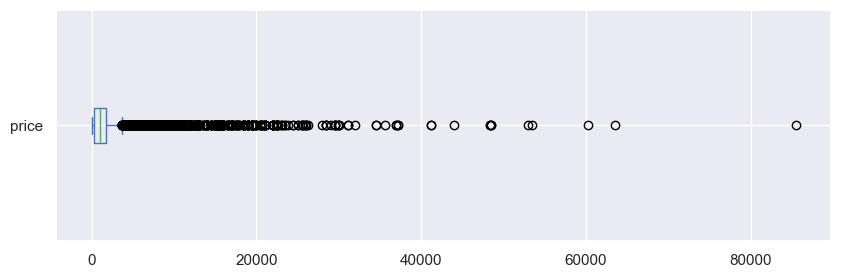

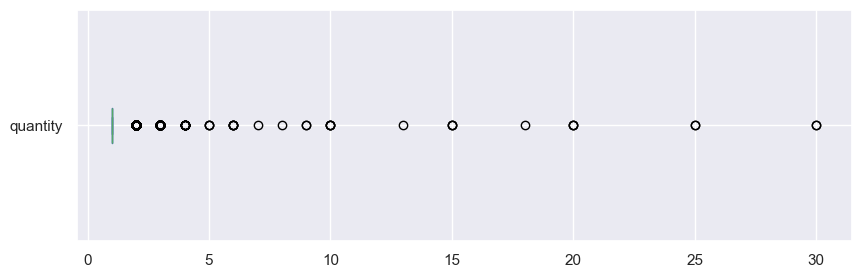

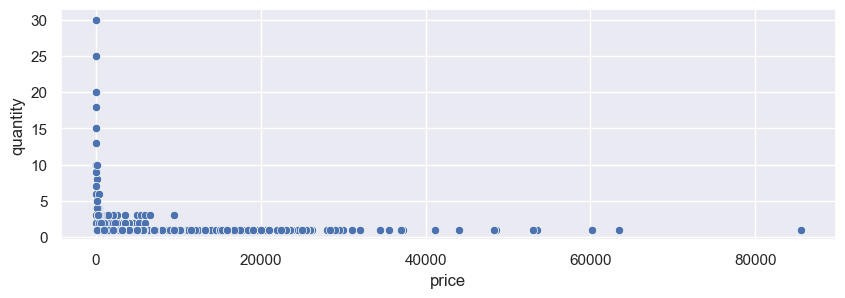

In [18]:
plots(apparel_purchases, 'price', 'quantity', scatter=True)

In [19]:
print('Количество строк до удаления', apparel_purchases.shape[0])
apparel_purchases = apparel_purchases.query('price <= 40000')
print('Количество строк после удаления', apparel_purchases.shape[0])

Количество строк до удаления 202208
Количество строк после удаления 202196


## Feature extraction/engineering и cоздание датасета

### Выделение признаков из `apparel_messages`

In [20]:
apparel_messages['year'] = apparel_messages['date'].dt.year.astype('str')
apparel_messages['month'] = apparel_messages['date'].dt.month.astype('str')
apparel_messages['event']
apparel_messages.head(2)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,year,month
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,2022,5
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,2022,5


In [21]:
# Считаем все виды действий пользователей
actions_count = apparel_messages.groupby(['client_id', 'event'])['event'].agg(['count'])\
                                .unstack().fillna(0).droplevel(level=0, axis=1).reset_index()


# Считаем все виды каналов 
channels_count = apparel_messages.groupby(['client_id', 'channel'])['channel'].agg(['count'])\
                                .unstack().fillna(0).droplevel(level=0, axis=1).reset_index()




print(f'Размерность actions_count - {actions_count.shape}')
print(f'Размерность channels_count - {channels_count.shape}')
actions_count.head(2)

Размерность actions_count - (53329, 12)
Размерность channels_count - (53329, 3)


event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0


In [22]:
# Датафрейм с количеством действий по видам за 2022 - 2024 года
actions_count_year = apparel_messages.pivot_table(index='client_id', columns=['year', 'event'], 
                             values='bulk_campaign_id', aggfunc='count').fillna(0)

actions_count_year.columns = ['_'.join(col) for col in actions_count_year.columns]

# Количество "хороших" действий по годам
actions_count_year['good_actions_2022'] = actions_count_year[['2022_click', '2022_open', '2022_purchase', '2022_subscribe']].sum(axis=1)
actions_count_year['good_actions_2023'] = actions_count_year[['2023_click', '2023_open', '2023_purchase', '2023_subscribe']].sum(axis=1)
actions_count_year['good_actions_2024'] = actions_count_year[['2024_click', '2024_open', '2024_purchase', '2024_subscribe']].sum(axis=1)

# Количество плохих действий по годам
actions_count_year['bad_actions_2022'] = actions_count_year[['2022_complain', '2022_hbq_spam', '2022_unsubscribe']].sum(axis=1)
actions_count_year['bad_actions_2023'] = actions_count_year[['2023_click', '2023_open', '2023_purchase', '2023_subscribe']].sum(axis=1)
actions_count_year['bad_actions_2024'] = actions_count_year[['2024_click', '2024_open', '2024_purchase', '2024_subscribe']].sum(axis=1)

actions_count_year.head(2)

,2022_click,2022_complain,2022_hard_bounce,2022_hbq_spam,2022_open,2022_purchase,2022_send,2022_soft_bounce,2022_subscribe,2022_unsubscribe,...,2024_send,2024_soft_bounce,2024_subscribe,2024_unsubscribe,good_actions_2022,good_actions_2023,good_actions_2024,bad_actions_2022,bad_actions_2023,bad_actions_2024
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,8.0,0.0,0.0,0.0,17.0,5.0,49.0,0.0,0.0,0.0,...,6.0,0.0,0.0,1.0,30.0,14.0,6.0,0.0,14.0,6.0
1515915625468061003,0.0,0.0,0.0,0.0,1.0,0.0,57.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,10.0,0.0


In [23]:
# Датафрейм с количеством каналов за 2022 - 2024 года
channels_count_year = apparel_messages.pivot_table(index='client_id', 
                                                   columns=['year', 'channel'], 
                                                   values='bulk_campaign_id',
                                                   aggfunc='count')\
                                      .fillna(0)


channels_count_year.columns = ['_'.join(col) for col in channels_count_year.columns]
channels_count_year.head(2)

,2022_email,2022_mobile_push,2023_email,2023_mobile_push,2024_email,2024_mobile_push
client_id,,,,,,
1515915625468060902,79.0,0.0,85.0,0.0,13.0,0.0
1515915625468061003,58.0,0.0,98.0,0.0,9.0,0.0


In [24]:
%time
apparel_messages['year_month'] = apparel_messages['date'].dt.year.astype('str') + '-' + apparel_messages['date'].dt.month.astype('str')
apparel_messages['year_month'].unique()

CPU times: total: 0 ns
Wall time: 0 ns


array(['2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10',
       '2022-11', '2022-12', '2023-1', '2023-2', '2023-3', '2023-4',
       '2023-5', '2023-6', '2023-7', '2023-8', '2023-9', '2023-10',
       '2023-11', '2023-12', '2024-1', '2024-2'], dtype=object)

In [25]:
# Количество действий по годам и месяцам для каждого пользователя
actions_count_year_month = apparel_messages.pivot_table(index='client_id',
                                                           columns=['year_month', 'event'], 
                                                           values='bulk_campaign_id',
                                                           aggfunc='count')\
                                            .fillna(0).reset_index()
                                              

actions_count_year_month.columns = ['client_id'] + ['_'.join(col) for col in actions_count_year_month.columns[1:]]

print(f'Размерность actions_count - {actions_count_year_month.shape}')
actions_count_year_month.head(2)

Размерность actions_count - (53329, 190)


,client_id,2022-10_click,2022-10_hard_bounce,2022-10_hbq_spam,2022-10_open,2022-10_purchase,2022-10_send,2022-10_soft_bounce,2022-10_subscribe,2022-10_unsubscribe,...,2024-1_soft_bounce,2024-1_subscribe,2024-1_unsubscribe,2024-2_click,2024-2_hard_bounce,2024-2_open,2024-2_purchase,2024-2_send,2024-2_soft_bounce,2024-2_unsubscribe
0,1515915625468060902,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468061003,0.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0


In [26]:
# Количество действий по годам и месяцам для каждого пользователя
channels_count_year_month = apparel_messages.pivot_table(index='client_id',
                                                   columns=['year_month', 'channel'], 
                                                   values='bulk_campaign_id',
                                                   aggfunc='count')\
                                              .fillna(0).reset_index()

channels_count_year_month.columns = ['client_id'] + ['_'.join(col) for col in channels_count_year_month.columns[1:]]


channels_count_year_month.head(2)

,client_id,2022-10_email,2022-10_mobile_push,2022-11_email,2022-11_mobile_push,2022-12_email,2022-12_mobile_push,2022-5_email,2022-5_mobile_push,2022-6_email,...,2023-7_email,2023-7_mobile_push,2023-8_email,2023-8_mobile_push,2023-9_email,2023-9_mobile_push,2024-1_email,2024-1_mobile_push,2024-2_email,2024-2_mobile_push
0,1515915625468060902,5.0,0.0,14.0,0.0,6.0,0.0,15.0,0.0,15.0,...,6.0,0.0,6.0,0.0,4.0,0.0,13.0,0.0,0.0,0.0
1,1515915625468061003,10.0,0.0,12.0,0.0,9.0,0.0,4.0,0.0,6.0,...,12.0,0.0,11.0,0.0,9.0,0.0,5.0,0.0,4.0,0.0


Добавим также счетчик "плохих" и "хороших" действий.

### Агрегация данных из `apparel_purchases`

В данной таблице нужно обработать как минимум следующие столбцы:
   - `category_ids` - это признак с огромным числом категорий, который обязательно нужно обработать;
   - `date` - нужно выделить из него признаки.
   - `quantity` и `price` - лучше агрегировать эти признаки по клиентам.

В списках категорий находятся вложенные категории (например автотовары-аксессуары-освежители). При этом в начале может быть маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`. 



Один из способов обработки этого признака - использовать "основные", наиболее общие категории. Возможно, самая важная категория - это последняя (самая точная, конечная). Также можно создать подкатегории с конца. Помимо этого, можно создать несколько признаков с объединением разных категорий. Например, "первая-последняя", "предпоследняя-последняя". Далее, можно ограничить число категорий каким-то числом (50 или 100), а остальные добавить в "другое".


Возможно, нужно взять самую общую категорию (например, первую), чтобы не создавать много шума в данных.


Можно выделить следующие значимые признаки:
   - общее количество товаров, купленных каждый клиентом;
   - совокупная выручка, принесенная каждым клиентом;
   - количетсво покупок в разных категориях.

Каждый из этих признаков можно выделить по годам, годам и месяцам и т.д.

In [27]:
# Выделим самые популярные категории
#top_cats = apparel_purchases['category_ids'].apply(lambda x: f'cat_{x[0]}' if len(x) >= 1 else 'nothing').value_counts().head(50).index

# Добавляем признак категорий
apparel_purchases['cats'] = apparel_purchases['category_ids'].apply(lambda x: f'cat_{x[0]}' if len(x) >= 1 else 'nothing')
#                                                             .apply(lambda x: x if x in top_cats else 'другой')

# Создаем признак год-месяц
apparel_purchases['year_month_purchase'] =\
                apparel_purchases['date'].dt.year.astype('str') + '-' +\
                                            apparel_purchases['date'].dt.month.astype('str')

# Создаем признак с годом
apparel_purchases['year'] =\
                apparel_purchases['date'].dt.year

apparel_purchases.head(2)

,client_id,quantity,price,category_ids,date,message_id,cats,year_month_purchase,year
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,cat_4,2022-5,2022
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,cat_4,2022-5,2022


Теперь нужно обработать признаки `quantity` и `price`, агрегируя их по клиентам. Вначале найдем выручку каждого клиетна от каждой покупки, а затем найдем совокупную или среднюю выручку на одного клиента.

In [28]:
# Находим выручку и количество купленных товаров на каждого пользователя от каждой покупки
apparel_purchases['revenue'] = apparel_purchases['quantity'] * apparel_purchases['price']

# Находим агрегирующую выручку по клиентам
aggregated_revenue = apparel_purchases.groupby('client_id')[['revenue', 'quantity']]\
                                      .agg({'revenue': 'sum', 'quantity': 'sum'})\
                                      .reset_index()


# Находим выручку и количество купленных товаров на каждого пользователя от каждой покупки по годам
aggregated_revenue_year = apparel_purchases.pivot_table(values='revenue', index='client_id', columns='year', aggfunc='sum')\
                                           .fillna(0)
aggregated_revenue_year.columns = [f'revenue_{year}' for year in (2022, 2023, 2024)]


# Находим выручку и количество купленных товаров на каждого пользователя от каждой покупки по годам-месяцам
aggregated_revenue_year_month = apparel_purchases.pivot_table(values='revenue', index='client_id', columns='year_month_purchase',
                                                        aggfunc='sum')\
                                                 .fillna(0)

aggregated_revenue_year_month.columns = [f'revenue_{c}' for c in aggregated_revenue_year_month.columns]


# Объединим все в 1 датасет
aggregated_revenue = aggregated_revenue.merge(aggregated_revenue_year, on='client_id')

# Добавим квадраты признаков
aggregated_revenue[['revenue_sq', 'quantity_sq', 'revenue_2022_sq', 'revenue_2023_sq', 'revenue_2024_sq']] = aggregated_revenue[['revenue', 'quantity', 'revenue_2022', 'revenue_2023', 'revenue_2024']]**2


print(f'Размерность агрегированной выручки - {aggregated_revenue.shape}')
aggregated_revenue.head(2)

Размерность агрегированной выручки - (49845, 11)


,client_id,revenue,quantity,revenue_2022,revenue_2023,revenue_2024,revenue_sq,quantity_sq,revenue_2022_sq,revenue_2023_sq,revenue_2024_sq
0,1515915625468060902,6993.0,7,6993.0,0.0,0.0,48902049.0,49,48902049.0,0.0,0.0
1,1515915625468061003,16235.0,7,0.0,16235.0,0.0,263575225.0,49,0.0,263575225.0,0.0


In [29]:
categories_purchases_count = apparel_purchases.pivot_table(values='price', index='client_id',
                                                           columns='cats', aggfunc='count')\
                                              .fillna(0).reset_index()

print(f'Размерность числа категорий - {categories_purchases_count.shape}')
categories_purchases_count.head(2)

Размерность числа категорий - (49845, 11)


cats,client_id,cat_1,cat_2,cat_3,cat_4,cat_5,cat_5562,cat_5963,cat_6060,cat_None,nothing
0,1515915625468060902,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468061003,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
year_month_purchases = apparel_purchases.pivot_table(values='quantity', index='client_id',
                                  columns='year_month_purchase', aggfunc='count').fillna(0).reset_index()

print(f'Размерность числа покупок по годам-месяцам - {year_month_purchases.shape}')
year_month_purchases.head(2)

Размерность числа покупок по годам-месяцам - (49845, 23)


year_month_purchase,client_id,2022-10,2022-11,2022-12,2022-5,2022-6,2022-7,2022-8,2022-9,2023-1,...,2023-2,2023-3,2023-4,2023-5,2023-6,2023-7,2023-8,2023-9,2024-1,2024-2
0,1515915625468060902,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1515915625468061003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Итак, были выделены основыне признаки из таблицы `apparel_purchases`.

### Агрегация данных из `full_campaign_daily_event` и `full_campaign_daily_event_channel`

Из датасетов `full_campaign_daily_event` и `full_campaign_daily_event_channel` можно получить информацию об эффективности тех или иных рассылок. Можно узнать, сколько пользователей отреагировало на рассылку тем или иным образом.

In [31]:
campaigns_aggregate = full_campaign_daily_event.groupby('bulk_campaign_id')\
                                        [full_campaign_daily_event.columns[2:]]\
                                        .sum()\
                                        .reset_index()
campaigns_aggregate.head(3)

,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,548,0,0,0,5,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
1,563,37,6,0,49,1,0,0,0,0,...,48,1,0,0,0,0,0,0,0,0
2,577,0,4,0,133,0,0,0,0,7,...,131,0,0,0,0,7,0,0,0,0


In [32]:
campaigns_channels_aggregate = full_campaign_daily_event_channel.groupby('bulk_campaign_id')\
                                        [full_campaign_daily_event_channel.columns[2:]]\
                                        .sum()\
                                        .reset_index()
campaigns_channels_aggregate.head(3)

,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,548,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,563,37,0,49,0,1,0,0,0,0,...,0,0,0,0,0,0,6,6,0,0
2,577,0,0,133,0,0,0,0,0,7,...,0,0,0,0,0,0,4,4,0,0


На основании вышеперечисленных данных можно выделить хорошие рассылочные кампании и плохие по тем или иным критериям. Основные критерии "хорошей" рассылки - покупка в результате рассылки, количество кликов, подписок и т.п. Основные критерии "плохой" рассылки  - отписка, жалоба спам.

Можно в будущем добавить сумму/среднее количество перечисленных показателей в готовый датасет.

In [33]:
campaigns_data = apparel_messages.merge(campaigns_aggregate, on='bulk_campaign_id')\
                        .groupby('client_id')[campaigns_aggregate.columns[1:]]\
                        .agg('mean').reset_index()

campaigns_data.columns = ['client_id'] + ['campaign_' + c for c in campaigns_data.columns[1:]]

campaigns_data.head(2)

,client_id,campaign_count_click,campaign_count_complain,campaign_count_hard_bounce,campaign_count_open,campaign_count_purchase,campaign_count_send,campaign_count_soft_bounce,campaign_count_subscribe,campaign_count_unsubscribe,...,campaign_nunique_open,campaign_nunique_purchase,campaign_nunique_send,campaign_nunique_soft_bounce,campaign_nunique_subscribe,campaign_nunique_unsubscribe,campaign_count_hbq_spam,campaign_nunique_hbq_spam,campaign_count_close,campaign_nunique_close
0,1515915625468060902,21643.768362,396.067797,3802.604520,205640.807910,203.045198,2.103680e+06,12243.124294,72.661017,3076.683616,...,199347.248588,160.361582,2.102091e+06,12179.581921,69.429379,2880.807910,182.073446,181.644068,0.0,0.0
1,1515915625468061003,22044.696970,349.527273,4830.066667,196638.824242,202.260606,2.107041e+06,11595.806061,77.690909,3259.981818,...,191016.393939,161.836364,2.105012e+06,11451.709091,74.096970,3051.236364,436.618182,436.430303,0.0,0.0


### Создание конечного датасета

In [34]:
# client_id должны быть уникальными
assert apparel_target_binary.shape[0] == apparel_target_binary['client_id'].nunique()
print(f'Количество клиентов в целевом датасете - {apparel_target_binary.shape[0]}')

Количество клиентов в целевом датасете - 49849


Теперь попробуем сконструировать датасет из всех сделанных выше агрегаций.

In [35]:
# actions_count_year_month
# channels_count_year_month
# aggregated_revenue_year_month
# categories_purchases_count

# Good results: aggregated_revenue + campaigns_data + actions_count_year

Плохо влияют на модель: `aggregated_revenue_year_month`, `categories_purchases_count`, `categories_purchases_count`, `channels_count`.

In [36]:
all_data = apparel_target_binary.merge(aggregated_revenue, on='client_id', how='left')\
                                .merge(actions_count_year, on='client_id', how='left')\
                                .merge(campaigns_data, on='client_id', how='left')\
                                .merge(channels_count, on='client_id', how='left')\
                                #.merge(year_month_purchases, on='client_id', how='left')
                                #.merge(channels_count, on='client_id', how='left')\
                                #.merge(categories_purchases_count, on='client_id', how='left')\
                                #.merge(channels_count_year, on='client_id', how='left')
                                #.merge(actions_count, on='client_id', how='left')\
                                

all_data = all_data.set_index('client_id')

print(f'Размерность готового датасета - {all_data.shape}')
all_data.head()

Размерность готового датасета - (49849, 71)


,target,revenue,quantity,revenue_2022,revenue_2023,revenue_2024,revenue_sq,quantity_sq,revenue_2022_sq,revenue_2023_sq,...,campaign_nunique_send,campaign_nunique_soft_bounce,campaign_nunique_subscribe,campaign_nunique_unsubscribe,campaign_count_hbq_spam,campaign_nunique_hbq_spam,campaign_count_close,campaign_nunique_close,email,mobile_push
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,6993.0,7.0,6993.0,0.0,0.0,4.890205e+07,49.0,48902049.0,0.000000e+00,...,2.102091e+06,12179.581921,69.429379,2880.807910,182.073446,181.644068,0.000000,0.000000,177.0,0.0
1515915625468061003,1,16235.0,7.0,0.0,16235.0,0.0,2.635752e+08,49.0,0.0,2.635752e+08,...,2.105012e+06,11451.709091,74.096970,3051.236364,436.618182,436.430303,0.000000,0.000000,165.0,0.0
1515915625468061099,0,299.0,1.0,299.0,0.0,0.0,8.940100e+04,1.0,89401.0,0.000000e+00,...,1.657005e+06,7310.289855,44.094203,1867.014493,780.376812,780.155797,0.000000,0.000000,182.0,94.0
1515915625468061100,0,2098.0,2.0,0.0,0.0,2098.0,4.401604e+06,4.0,0.0,0.000000e+00,...,1.424335e+06,360.932243,0.000000,0.000000,0.000000,0.000000,0.007009,0.007009,0.0,428.0
1515915625468061170,0,33601.0,19.0,0.0,33601.0,0.0,1.129027e+09,361.0,0.0,1.129027e+09,...,2.271494e+06,7495.122867,43.262799,1701.320819,242.078498,241.955631,0.000000,0.000000,202.0,91.0


Получившийся датасет сохранил все объекты из целевого датасета. При этом получилось более 378 признаков.

## Обучение модели

### Разделение на тренировочную и тестовую выборки

In [37]:
X, y = all_data.drop('target', axis=1), all_data['target']

X.columns = X.columns.astype(str)

print(X.shape)
print(y.shape)

(49849, 70)
(49849,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE,
                                                   stratify=all_data['target'])

print('Размерность X_train -', X_train.shape)
print('Размерность X_test -', X_test.shape)
print('Размерность y_train -', y_train.shape)
print('Размерность y_test -', y_test.shape)

Размерность X_train - (37386, 70)
Размерность X_test - (12463, 70)
Размерность y_train - (37386,)
Размерность y_test - (12463,)


In [39]:
# Выбираем количественные и категориальные признаки
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

### Создание пайплайна

In [40]:
# Pipe for categorical data
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value='unknown')),
                     ('encoder', OneHotEncoder(sparse_output=False,  handle_unknown='ignore', drop='first'))])

# Pipe for numerical data
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0)),
                     ('scaler', StandardScaler())
                    ])
                     
# Preprocessing pipe
preprocessing_pipe = ColumnTransformer([('num_preprocessor', num_pipe, num_cols),
                                        ('cat_preprocessor', cat_pipe, cat_cols),
                                       ])

# Final pipe
final_pipe = Pipeline([('preprocessor', preprocessing_pipe),
                       ('model', LogisticRegression(class_weight='balanced',  random_state=RANDOM_STATE))
                      ])

### baseline модель: обучение и валидация модели

Обучим baseline-модель и посмотрим на результаты. Также определим функцию для расчета основных метрик классификации.

In [41]:
# Функция для расчета основных метрик
def metrics(model, data_X_train, data_y_train, data_X_test, data_y_test, prob=True):
    # Расчитаем основную метрику для кросс-валидации
    roc_auc_crossval = cross_val_score(model, data_X_train, data_y_train, scoring='roc_auc', cv=3).mean()
    
    # Сделаем предсказание
    y_pred = model.predict(data_X_test)
    
    if prob:
        probs = model.predict_proba(data_X_test)[:, 1]
    
    # Расчитаем другие метрики на тесте
    roc_auc_test = roc_auc_score(data_y_test, probs)
    accuracy = accuracy_score(y_pred, data_y_test)
    f1 = f1_score(y_pred, data_y_test)
    precision = precision_score(y_pred, data_y_test)
    recall = recall_score(y_pred, data_y_test)
    
    
    return pd.DataFrame([roc_auc_crossval, roc_auc_test, accuracy, f1, precision, recall],
                 index=['roc_auc_crossval', 'roc_auc_test', 'accuracy', 'f1', 'precision', 'recall'],
                 columns=['metrics']).round(2)

In [42]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['revenue', 'quantity', 'revenue_2022', 'revenue_2023', 'revenue_2024',
       'revenue_sq', 'quantity_sq', 'revenue_2022_sq', 'revenue_2023_sq',
       'revenue_2024_sq', '2022_...
       'campaign_count_close', 'campaign_nunique_close', 'email',
       'mobile_push'],
      dtype='object')),
                                                 ('cat_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index([], dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=17))])

In [43]:
metrics(final_pipe, X_train, y_train, X_test, y_test)

,metrics
roc_auc_crossval,0.75
roc_auc_test,0.73
accuracy,0.76
f1,0.09
precision,0.59
recall,0.05


Baseline модель показала неплохой результат на метрике `roc_auc`. На других метриках - результат плох. Попробуем подобрать гиперпараметры для модели, добавив регуляризацию.

In [44]:
params_lg = [{'model': [LogisticRegression(class_weight='balanced',  random_state=RANDOM_STATE)],
              'model__C': np.arange(0.01, 0.9, 0.05),
              'model__max_iter': [100, 150, 200, 250]
             }]

In [45]:
rs = RandomizedSearchCV(final_pipe, params_lg, n_iter=15, scoring='roc_auc', cv=3, random_state=RANDOM_STATE, verbose=3)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END model=LogisticRegression(class_weight='balanced', random_state=17), model__C=0.26, model__max_iter=150;, score=0.768 total time=   0.6s
[CV 2/3] END model=LogisticRegression(class_weight='balanced', random_state=17), model__C=0.26, model__max_iter=150;, score=0.738 total time=   0.7s
[CV 3/3] END model=LogisticRegression(class_weight='balanced', random_state=17), model__C=0.26, model__max_iter=150;, score=0.757 total time=   0.6s
[CV 1/3] END model=LogisticRegression(class_weight='balanced', random_state=17), model__C=0.51, model__max_iter=250;, score=0.768 total time=   0.8s
[CV 2/3] END model=LogisticRegression(class_weight='balanced', random_state=17), model__C=0.51, model__max_iter=250;, score=0.738 total time=   0.8s
[CV 3/3] END model=LogisticRegression(class_weight='balanced', random_state=17), model__C=0.51, model__max_iter=250;, score=0.757 total time=   0.8s
[CV 1/3] END model=LogisticRegression(class_w

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_preprocessor',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['revenue', 'quantity', 'revenue_2022', 'revenue_2023', 'revenue_2024',
       'revenue_sq', 'quantity_sq', 'revenue_2022_sq', 'revenue...
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=17))]),
                   n_iter=15,
                   param_distributions=[{'model': [LogisticRegression(class_weight='balanced',
                                                                      random_state=17)],
                                         'model__C': array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86]),
                                         'model__max_iter': [100, 150, 200,
                                                             250]}],
                   random_state=17, scoring='roc_auc', verbose=3)

In [46]:
lg = rs.best_estimator_

In [47]:
lg_metrics = metrics(lg, X_train, y_train, X_test, y_test)
lg_metrics

,metrics
roc_auc_crossval,0.75
roc_auc_test,0.73
accuracy,0.76
f1,0.09
precision,0.59
recall,0.05


В результате тюннинга результаты не улучшились. Возможно, модель очень простая, поэтому нужно просто попробовать другую модель.

### DecisionTreeClassifier

Попробуем обучить древо решений и посмотреть на результат. Древо решений обычно работает плохо с датасетом, где много количественных признаков.

In [48]:
params_tree = {'model': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
              'model__max_depth': [35, 50, 70, 100], 
              'model__min_samples_leaf': [50, 80, 100, 150, 200],
              'model__max_leaf_nodes': [40, 50, 70],
              'model__min_samples_split': [2, 5, 8, 10]
              }

In [49]:
rs = RandomizedSearchCV(final_pipe, params_tree, n_iter=15, scoring='roc_auc', cv=3, random_state=RANDOM_STATE, verbose=3)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END model=DecisionTreeClassifier(class_weight='balanced', random_state=17), model__max_depth=35, model__max_leaf_nodes=70, model__min_samples_leaf=100, model__min_samples_split=2;, score=0.704 total time=   1.0s
[CV 2/3] END model=DecisionTreeClassifier(class_weight='balanced', random_state=17), model__max_depth=35, model__max_leaf_nodes=70, model__min_samples_leaf=100, model__min_samples_split=2;, score=0.661 total time=   1.0s
[CV 3/3] END model=DecisionTreeClassifier(class_weight='balanced', random_state=17), model__max_depth=35, model__max_leaf_nodes=70, model__min_samples_leaf=100, model__min_samples_split=2;, score=0.683 total time=   0.9s
[CV 1/3] END model=DecisionTreeClassifier(class_weight='balanced', random_state=17), model__max_depth=100, model__max_leaf_nodes=50, model__min_samples_leaf=150, model__min_samples_split=10;, score=0.712 total time=   0.9s
[CV 2/3] END model=DecisionTreeClassifier(class_weigh

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_preprocessor',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=0,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['revenue', 'quantity', 'revenue_2022', 'revenue_2023', 'revenue_2024',
       'revenue_sq', 'quantity_sq', 'revenue_2022_sq', 'revenue...
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=17))]),
                   n_iter=15,
                   param_distributions={'model': [DecisionTreeClassifier(class_weight='balanced',
                                                                         random_state=17)],
                                        'model__max_depth': [35, 50, 70, 100],
                                        'model__max_leaf_nodes': [40, 50, 70],
                                        'model__min_samples_leaf': [50, 80, 100,
                                                                    150, 200],
                                        'model__min_samples_split': [2, 5, 8,
                                                                     10]},
                   random_state=17, scoring='roc_auc', verbose=3)

In [50]:
tree = rs.best_estimator_
tree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['revenue', 'quantity', 'revenue_2022', 'revenue_2023', 'revenue_2024',
       'revenue_sq', 'quantity_sq', 'revenue_2022_sq', 'revenue_2023_sq',
       'revenue_2024_sq', '2022_...
                                                 ('cat_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index([], dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=100,
                                        max_leaf_nodes=50, min_samples_leaf=150,
                                        min_samples_split=10,
                                        random_state=17))])

In [51]:
tree_metrics = metrics(tree, X_train, y_train, X_test, y_test)
tree_metrics

,metrics
roc_auc_crossval,0.71
roc_auc_test,0.69
accuracy,0.71
f1,0.07
precision,0.55
recall,0.04


С помощью тюннинга удалось добиться более менее вменяемого значения метрики `roc_auc`. Но значение остальных меток по-прежнему невелико.

### RandomForestClassifier

In [52]:
# RandomForest
params_rf = {'model': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
              'model__n_estimators': [150, 200, 250],
              'model__max_depth': [35, 50, 70, 100], 
              'model__min_samples_leaf': [50, 80, 100, 150],
             'model__max_leaf_nodes': [40, 50, 70]
            }

In [53]:
rs = RandomizedSearchCV(final_pipe, params_rf, n_iter=5, scoring='roc_auc', cv=3, random_state=RANDOM_STATE, verbose=3)
rs.fit(X_train, y_train)
rf = rs.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END model=RandomForestClassifier(class_weight='balanced', random_state=17), model__max_depth=35, model__max_leaf_nodes=70, model__min_samples_leaf=80, model__n_estimators=250;, score=0.774 total time=  18.2s
[CV 2/3] END model=RandomForestClassifier(class_weight='balanced', random_state=17), model__max_depth=35, model__max_leaf_nodes=70, model__min_samples_leaf=80, model__n_estimators=250;, score=0.755 total time=  27.4s
[CV 3/3] END model=RandomForestClassifier(class_weight='balanced', random_state=17), model__max_depth=35, model__max_leaf_nodes=70, model__min_samples_leaf=80, model__n_estimators=250;, score=0.768 total time=  19.1s
[CV 1/3] END model=RandomForestClassifier(class_weight='balanced', random_state=17), model__max_depth=35, model__max_leaf_nodes=50, model__min_samples_leaf=80, model__n_estimators=200;, score=0.778 total time=  12.8s
[CV 2/3] END model=RandomForestClassifier(class_weight='balanced', rando

In [54]:
rf_metrics = metrics(rf, X_train, y_train, X_test, y_test)
rf_metrics

,metrics
roc_auc_crossval,0.77
roc_auc_test,0.74
accuracy,0.83
f1,0.10
precision,0.52
recall,0.06


Метрики случайного леса оказались гораздо выше, чем у предыдущих моделей. Теперь попробуем бустинг.

### LightGBM Classifier

Нужно выбрать алгоритм бустинга, который бутдет быстро обучаться на датасете с большим количеством признаков. Быстрая реализация бустинга от Microsoft - LightGBM.

In [55]:
params_lgbm = {'model': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
              'model__n_estimators': [150, 200, 250],
              'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
              }

In [56]:
rs = RandomizedSearchCV(final_pipe, params_lgbm, n_iter=5, scoring='roc_auc', cv=3, random_state=RANDOM_STATE, verbose=3)
rs.fit(X_train, y_train)
lgbm = rs.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 481, number of negative: 24443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10280
[LightGBM] [Info] Number of data points in the train set: 24924, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV 1/3] END model=LGBMClassifier(class_weight='balanced', random_state=17), model__learning_rate=0.01, model__n_estimators=250;, score=0.773 total time=   2.3s
[LightGBM] [Info] Number of positive: 481, number of negative: 24443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10311
[LightGBM] [Info] Nu

In [57]:
lgbm_metrics = metrics(lgbm, X_train, y_train, X_test, y_test)
lgbm_metrics

[LightGBM] [Info] Number of positive: 481, number of negative: 24443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10280
[LightGBM] [Info] Number of data points in the train set: 24924, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 481, number of negative: 24443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10311
[LightGBM] [Info] Number of data points in the train set: 24924, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [In

,metrics
roc_auc_crossval,0.76
roc_auc_test,0.73
accuracy,0.81
f1,0.09
precision,0.52
recall,0.05


Метрика `roc_auc` хуже, чем на дереве решений, но лучше, чем на базовой модели. Теперь попробуем объединить лучшие модели в ансамбль.

### SMOTE (oversampling) и ансамбль

Для улучшения отобранных моделей можно попробовать сделать 2 шага:
1) сбалансировать классы в целевом признаке: oversampling или undersampling;

2) сделать ансамбль лучших моделей: `StackingClassifier` или `VotingClassifier`.

К сожалению, ансамбль из ансамблей моделей имеет низкую производительность. Поэтому я выполню только 1 пункт.

In [58]:
all_metrics = pd.concat([lg_metrics, tree_metrics, rf_metrics, lgbm_metrics], axis=1)
all_metrics.columns = ['logreg', 'tree', 'random_forest', 'lgbm']
all_metrics

,logreg,tree,random_forest,lgbm
roc_auc_crossval,0.75,0.71,0.77,0.76
roc_auc_test,0.73,0.69,0.74,0.73
accuracy,0.76,0.71,0.83,0.81
f1,0.09,0.07,0.10,0.09
precision,0.59,0.55,0.52,0.52
recall,0.05,0.04,0.06,0.05


На данном этапе лучшеие модели по `roc_auc` - случайный лес и lgbm. При этом неплохой и быстрой моделью также является логистическая регрессия, которая имеет лучший `precision`.

Интегрировать в пайплайн SMOTE сложно. Поэтому придется реализовать его отдельно.

In [59]:
# Трансформируем данные:
X_train_transf, X_test_transf = preprocessing_pipe.fit_transform(X_train), preprocessing_pipe.transform(X_test)

# Реализация SMOTE'а
smote = SMOTE(random_state=RANDOM_STATE)
X_train_transf, y_train_transf = smote.fit_resample(X_train_transf, y_train)

X_train_transf, X_test_transf = pd.DataFrame(X_train_transf, columns=preprocessing_pipe.get_feature_names_out()),\
                                pd.DataFrame(X_test_transf, columns=preprocessing_pipe.get_feature_names_out())

In [60]:
# Результаты логистической регрессии на SMOTE-данных
lg_smote_metrics = metrics(lg['model'], X_train_transf, y_train_transf, X_test_transf, y_test)
lg_smote_metrics

,metrics
roc_auc_crossval,0.78
roc_auc_test,0.73
accuracy,0.76
f1,0.09
precision,0.59
recall,0.05


In [61]:
# Результаты случайного леса на SMOTE-данных
rf_smote_metrics = metrics(rf['model'], X_train_transf, y_train_transf, X_test_transf, y_test)
rf_smote_metrics

,metrics
roc_auc_crossval,0.93
roc_auc_test,0.74
accuracy,0.83
f1,0.10
precision,0.52
recall,0.06


In [62]:
# Результаты бустинга на SMOTE-данных
lgbm_smote_metrics = metrics(lgbm['model'], X_train_transf, y_train_transf, X_test_transf, y_test)
lgbm_smote_metrics

[LightGBM] [Info] Number of positive: 24443, number of negative: 24443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14762
[LightGBM] [Info] Number of data points in the train set: 48886, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 24444, number of negative: 24443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14770
[LightGBM] [Info] Number of data points in the train set: 48887, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 24443, number of negative: 

,metrics
roc_auc_crossval,0.98
roc_auc_test,0.73
accuracy,0.81
f1,0.09
precision,0.52
recall,0.05


In [63]:
all_metrics_smote = pd.concat([lg_smote_metrics, rf_smote_metrics, lgbm_smote_metrics], axis=1)
all_metrics_smote.columns = ['logreg_smote', 'random_forest_smote', 'lgbm_smote']
all_metrics_smote

,logreg_smote,random_forest_smote,lgbm_smote
roc_auc_crossval,0.78,0.93,0.98
roc_auc_test,0.73,0.74,0.73
accuracy,0.76,0.83,0.81
f1,0.09,0.10,0.09
precision,0.59,0.52,0.52
recall,0.05,0.06,0.05


После smote метрика `roc_auc` улучшилась значительно на кросс валидации. Но при этом на тесте метрика несильно увеличилась.

## Финальная оценка модели - бизнес-задача

Теперь выберем лучшую модель по целевой метрике `roc_auc` и посмотрим, как она справляется с поставленной бизнес задачей.

Рассмотрим, как модель справляется с бизнес задачей.

In [64]:
pd.concat([all_metrics, all_metrics_smote], axis=1)

,logreg,tree,random_forest,lgbm,logreg_smote,random_forest_smote,lgbm_smote
roc_auc_crossval,0.75,0.71,0.77,0.76,0.78,0.93,0.98
roc_auc_test,0.73,0.69,0.74,0.73,0.73,0.74,0.73
accuracy,0.76,0.71,0.83,0.81,0.76,0.83,0.81
f1,0.09,0.07,0.10,0.09,0.09,0.10,0.09
precision,0.59,0.55,0.52,0.52,0.59,0.52,0.52
recall,0.05,0.04,0.06,0.05,0.05,0.06,0.05


Здесь в качестве лучшей модели выберем случайный лес. Из метрик видно, что модель очень плохо находит объекты класса $1$ , т.е. покупателей, которые совершат покупку. Т.е. модель часто совершает ошибку второго рода. При этом модель удовлетворительно дает положительные предсказания. 

В целом модель показывает достаточно низкие результаты, чтобы использовать её в production.